# Laboratorium 2


### Konfiguracja

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes

    def set_axis(self, ax):
        self.ax = ax
        
    def next(self, event):
        self.i = (self.i + 1) % len(scenes)
        self.draw()

    def prev(self, event):
        self.i = (self.i - 1) % len(scenes)
        self.draw()
        
    def draw(self):
        self.ax.clear()
        for collection in self.scenes[self.i].points:
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), c=collection.color, marker=collection.marker)
        for collection in self.scenes[self.i].lines:
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale()
        plt.draw()

### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [2]:
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

class PointsCollection:
    def __init__(self, points = [], color = None, marker = None):
        self.points = np.array(points)
        self.color = color
        self.marker = marker

class LinesCollection:
    def __init__(self, lines = [], color = None):
        self.color = color
        self.lines = lines
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        if self.color:
            return mcoll.LineCollection(self.lines, colors=mcolors.to_rgba(self.color))
        else:
            return mcoll.LineCollection(self.lines)
            


class Plot:
    def __init__(self, scenes = [], json = None):
        if json is None:
            self.scenes = scenes
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
        
    def __configure_buttons(self, callback):
        plt.subplots_adjust(bottom=0.2)
        axprev = plt.axes([0.6, 0.05, 0.15, 0.075])
        axnext = plt.axes([0.76, 0.05, 0.15, 0.075])
        bnext = Button(axnext, 'Następny')
        bnext.on_clicked(callback.next)
        bprev = Button(axprev, 'Poprzedni')
        bprev.on_clicked(callback.prev)
        return [bprev, bnext]

    def draw(self):
        plt.close()
        callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons(callback)
        callback.set_axis(plt.axes())
        plt.show()
        callback.draw()
        
    def toJSON(self):
        return js.dumps([{"points": [pointCol.points.tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])
    

### Rozwiązanie

### Funkcje generujące zbiory

In [3]:
import random
import math
import copy

def genSet1 (n = 100, xmin = -100, xmax = 100, ymin = -100, ymax = 100):
    set1 = []
    for i in range(n):
        set1.append(((random.uniform(xmin, xmax)), (random.uniform(ymin, ymax))))
    return set1

def genSet2 (n = 100, R = 10, ox = 0, oy = 0):
    set2 = []
    for i in range(n):
        alpha = 2 * math.pi * random.random()
        x = R * math.cos(alpha) + ox
        y = R * math.sin(alpha) + oy
        set2.append((x, y))
    return set2

def genSet3 (n = 100, P = [(-10, 10), (-10, -10), (10, -10), (10, 10)]):
    set3 = []
    if (P[0][0] - P[1][0] == 0 or P[0][1] - P[1][1] == 0): #boki równoległe do osi ukł. wsp.
        T = [[P[0][0], P[0][1]], [P[0][0], P[0][1]]]
        for i in range(4):
            if (P[i][0] < T[0][0]):
                T[0][0] = P[i][0]
            if (P[i][1] < T[0][1]):
                T[0][1] = P[i][1]
            if (P[i][0] > T[1][0]):
                T[1][0] = P[i][0]
            if (P[i][0] > T[1][0]):
                T[1][0] = P[i][0]
        P = [(T[0][0], T[0][1]), (T[1][0], T[0][1]), (T[1][0], T[1][1]), (T[0][0], T[1][1])]
        for i in range(n):
            l = random.randint(0, 3)
            if (l % 2 == 0):
                x = P[l][0] + random.random() * (P[l+1][0] - P[l][0])
                y = P[l][1]
            else:
                x = P[l][0]
                y = P[l][1] + random.random() * (P[(l+1) % 4][1] - P[l][1])
            set3.append((x, y))
    else: #dowolny prostokąt o bokach nierównoległych do osi ukł. wsp.
        a = []
        b = []
        for i in range(4):
            a.append((P[i][1] - P[(i+1) % 4][1]) / (P[i][0] - P[(i+1) % 4][0]))
            b.append(P[i][1] - P[i][0] * a[i])
        
        for i in range(n):
            l = random.randint(0, 3)
            x = P[l][0] + random.random() * (P[(l+1) % 4][0] - P[l][0])
            y = a[l] * x + b[l]
            set3.append((x, y))
    return set3

def genSet4(P = 10, axes = 25, diags = 20):
    set4 = [(0, 0), (P, 0), (P, P), (0, P)]
    for i in range(axes):
        set4.append((random.random() * P, 0))
        set4.append((0, random.random() * P))
        
    for i in range(diags):
        x = random.random() * P
        set4.append((x, x))
        x = random.random() * P
        set4.append((x, P - x))
    return set4

### Generowanie i wizualizacja wygenerowanych zbiorów

<IPython.core.display.Javascript object>


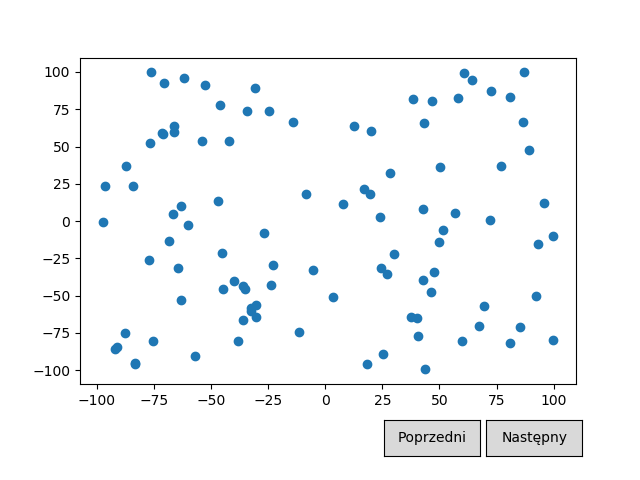

In [4]:
num = 100
sets = []
sets.append(genSet1(num))
sets.append(genSet2(num))
sets.append(genSet3(num))
sets.append(genSet3(num, [(0, 0), (1, -2), (4, 0), (3, 2)]))
sets.append(genSet4(10, int(num/2), int(num/2)))

%matplotlib notebook

scenes = [Scene([PointsCollection(sets[i])]) for i in range(len(sets))]

plot = Plot(scenes)
plot.draw() 

### Wyznacznik i funkcje pomocnicze

In [5]:
from functools import cmp_to_key

eps = 10 ** (-10)
def det(A, B, C):
    return A[0]*B[1] + B[0]*C[1] + C[0]*A[1] - C[0]*B[1] - A[0]*C[1] - B[0]*A[1]

def orient(A, B, C):
    d = det(A, B, C)
    if d > eps:
        return 1
    elif d < -eps:
        return -1
    else:
        return 0
    
def orientExt(A, B, C):
    if A == B:
        return 1
    if A == C:
        return -1
    d = det(A, B, C)
    if d > eps:
        return 1
    elif d < -eps:
        return -1
    else:
        if C[1] > B[1]:
            return -1
        elif B[1] > C[1]:
            return 1
        else:
            if C[0] > B[0]:
                return -1
            else:
                return 1

def orientSort(set, A):
    set.sort(key = cmp_to_key(lambda B, C : orientExt(A, C, B)))

In [6]:
def dist(A, B):
    dx = B[0] - A[0]
    dy = B[1] - A[1]
    return dx * dx + dy * dy

def nextPoint(set, A):
    B = A
    for C in set:
        o = orient(A, B, C)
        if o == -1 or o == 0 and dist(A, C) > dist(A, B):
            B = C
    return B

In [7]:
def findLowerLeft(set):
    result = 0
    for i in range(len(set)):
        if set[i][1] < set[result][1]:
            result = i
    for i in range(len(set)):
        if set[i][1] == set[result][1] and set[i][0] < set[result][0]:
            result = i
    return result

def findUpperRight(set):
    result = 0
    for i in range(len(set)):
        if set[i][1] > set[result][1]:
            result = i
    for i in range(len(set)):
        if set[i][1] == set[result][1] and set[i][0] > set[result][0]:
            result = i
    return result

### Algorytm Grahama

In [8]:
def graham(set):
    S = copy.deepcopy(set)
    start = findLowerLeft(S)
    A = S[start]
    orientSort(S, A)
    
    stack = [0, 1]
    for i in range(2, len(S)):
        while(True):
            A = stack[-2]
            B = stack[-1]
            C = i
            if orient(S[A], S[B], S[C]) == 1:
                stack.append(C)
                break
            else:
                stack.pop()
                if orient(S[0], S[B], S[C]) == 0:
                    if S[C][1] > S[B][1]:
                        stack.append(C)
                    elif S[C][1] < S[B][1]:
                        stack.append(B)
                    else:
                        if S[C][0] > S[B][0]:
                            stack.append(C)
                        else:
                            stack.append(B)
                    break
    if orient(S[0], S[-2], S[-1]) == 0:
        stack.pop(-1)
    result = [S[stack[i]] for i in range(len(stack))]
    return result

<IPython.core.display.Javascript object>


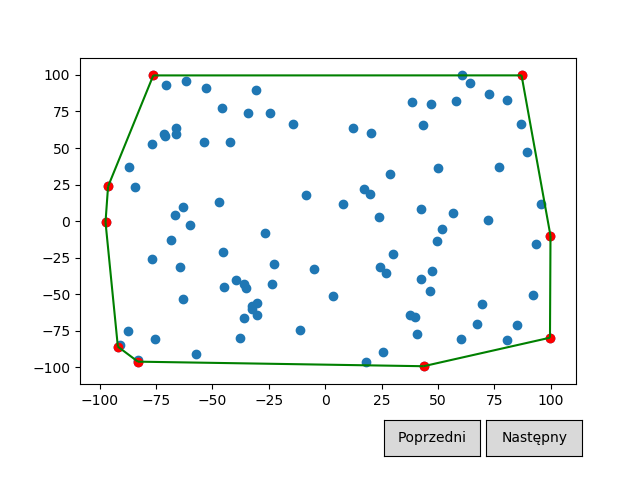

In [9]:
import datetime

durationsGraham = []
CH = []
for i in range(len(sets)):
    start = datetime.datetime.now()
    CH.append(graham(sets[i]))
    duration = datetime.datetime.now() - start
    durationsGraham.append(duration.seconds * 1000000 + duration.microseconds)

# Zapisanie wyniku do pliku
# f = open("graham_results.txt", "w")
# f.write("Algorytm Grahama\n")
# for i in range (len(CH)):
#    f.write("Wynik dla zbioru " + str(i) + ": " + str(CH[i]) + "\n")
#    f.write("Liczba punktow: " + str(len(CH[i])) + "\n\n")
# f.close() )

#Wizualizacja
%matplotlib notebook

scenes = [Scene([PointsCollection(sets[i]), PointsCollection(CH[i], 'red')],
              [LinesCollection([[CH[i][j], CH[i][(j+1) % len(CH[i])]] for j in range(len(CH[i]))], 'green')])
         for i in range(len(sets))]

plot = Plot(scenes)
plot.draw() 

### Algorytm Jarvisa

In [10]:
def jarvis(set):
    S = copy.deepcopy(set)
    startingPoint = S[findLowerLeft(S)]
    A = nextPoint(set, startingPoint)
    result = [startingPoint]
    
    while A != startingPoint:
        result.append(A)
        A = nextPoint(set, A)
    return result

<IPython.core.display.Javascript object>


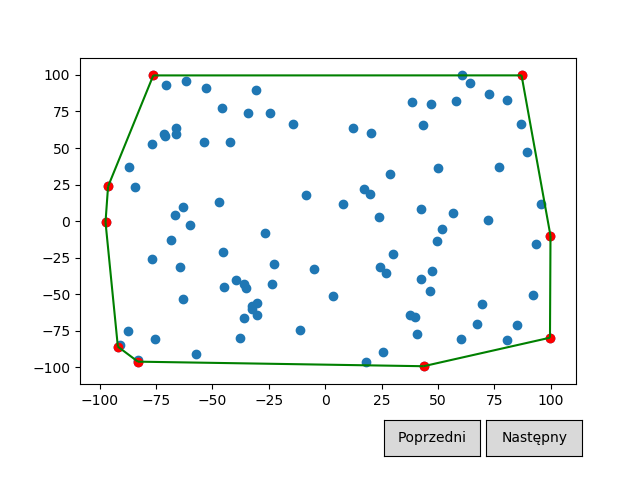

In [11]:
import datetime

durationsJarvis = []
CH = []
for i in range(len(sets)):
    start = datetime.datetime.now()
    CH.append(jarvis(sets[i]))
    duration = datetime.datetime.now() - start
    durationsJarvis.append(duration.seconds * 1000000 + duration.microseconds)

# Zapisanie wyniku do pliku
# f = open("jarvis_results.txt", "w")
# f.write("Algorytm Jarvisa\n")
# for i in range (len(CH)):
#    f.write("Wynik dla zbioru " + str(i) + ": " + str(CH[i]) + "\n")
#    f.write("Liczba punktow: " + str(len(CH[i])) + "\n\n")
# f.close() 

#Wizualizacja
%matplotlib notebook

scenes = [Scene([PointsCollection(sets[i]), PointsCollection(CH[i], 'red')],
              [LinesCollection([[CH[i][j], CH[i][(j+1) % len(CH[i])]] for j in range(len(CH[i]))], 'green')])
         for i in range(len(sets))]

plot = Plot(scenes)
plot.draw() 

### Porównanie czasów działania

In [12]:
#Działa poprawnie dla n >= 500
print("Czasy działania [ms]:")
print("   Graham   | Jarvis")
for i in range(len(sets)):
    print(i + 1, ": ", "%8i"%durationsGraham[i], " | ", "%8i"%durationsJarvis[i], sep = "")

Czasy działania [ms]:
   Graham   | Jarvis
1:     1995 |      998
2:        0 |     6981
3:      998 |      997
4:      997 |      997
5:     1994 |      998


### Wizualizacja działania algorytmu Grahama

<IPython.core.display.Javascript object>


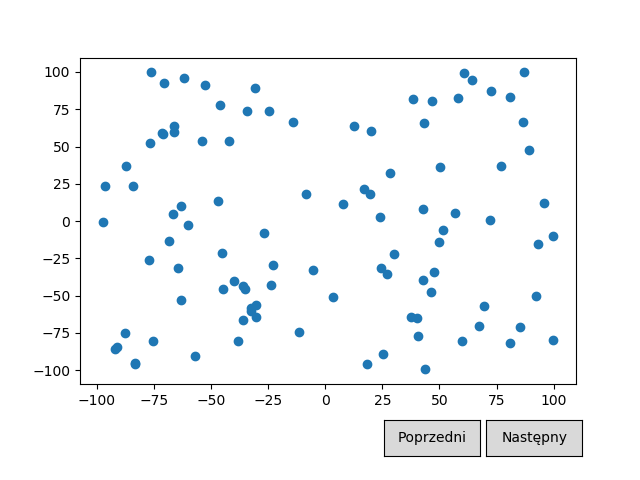

In [13]:
#Możliwość wyboru zbioru:
set = sets[0]

%matplotlib notebook

def grahamVis(set):
    S = copy.deepcopy(set)
    scenes = [(Scene([PointsCollection(S)]))]
    start = findLowerLeft(S)
    scenes.append(Scene([PointsCollection(S), PointsCollection([S[start]], 'red')]))
    A = S[start]
    orientSort(S, A)
    
    stack = [0, 1]
    
    scenes.append(Scene([PointsCollection(S), PointsCollection([S[stack[i]] for i in range(len(stack))], 'green')],
                       [LinesCollection([[S[stack[i]], S[stack[i + 1]]] for i in range(len(stack) - 1)], 'green')]))
    
    for i in range(2, len(S)):
        while(True):
            A = stack[-2]
            B = stack[-1]
            C = i
            
            scenes.append(Scene([PointsCollection(S), PointsCollection([S[stack[i]] for i in range(len(stack) - 2)], 'green'),
                                PointsCollection([S[A], S[B]], 'blue'), PointsCollection([S[C]], 'red')],
                       [LinesCollection([[S[stack[i]], S[stack[i + 1]]] for i in range(len(stack) - 2)], 'green'),
                       LinesCollection([[S[stack[-2]], S[stack[-1]]]], 'blue')]))
            
            if orient(S[A], S[B], S[C]) == 1:
                stack.append(C)
                
                scenes.append(Scene([PointsCollection(S), PointsCollection([S[stack[i]] for i in range(len(stack))], 'green')],
                       [LinesCollection([[S[stack[i]], S[stack[i + 1]]] for i in range(len(stack) - 1)], 'green')]))
                
                break
            else:
                stack.pop()
                if orient(S[0], S[B], S[C]) == 0:
                    if S[C][1] > S[B][1]:
                        stack.append(C)
                    elif S[C][1] < S[B][1]:
                        stack.append(B)
                    else:
                        if S[C][0] > S[B][0]:
                            stack.append(C)
                        else:
                            stack.append(B)
                    break
                else:
                    scenes.append(Scene([PointsCollection(S), PointsCollection([S[stack[i]] for i in range(len(stack))], 'green'),
                                PointsCollection([S[C]], 'red')],
                       [LinesCollection([[S[stack[i]], S[stack[i + 1]]] for i in range(len(stack) - 1)], 'green')]))
                    
    if orient(S[0], S[-2], S[-1]) == 0:
        stack.pop(-1)
        
    scenes.append(Scene([PointsCollection(S), PointsCollection([S[stack[i]] for i in range(len(stack))], 'green')],
                       [LinesCollection([[S[stack[i]], S[stack[(i + 1) % len(stack)]]] for i in range(len(stack))], 'green')]))
    
    return scenes

scenes = grahamVis(set)

plot = Plot(scenes)
plot.draw() 

### Wizualizacja działania algorytmu Jarvisa

<IPython.core.display.Javascript object>


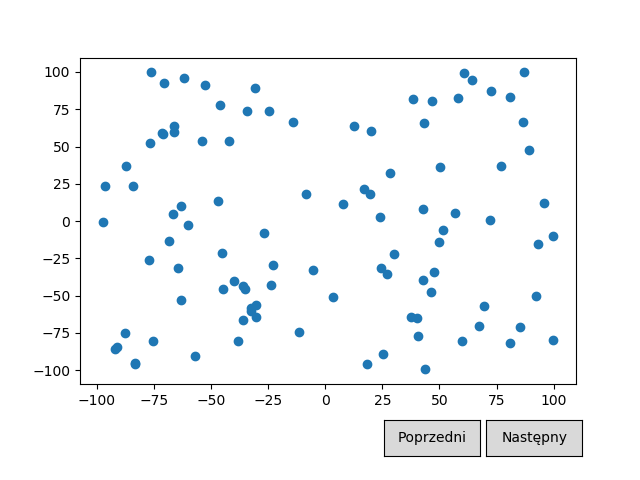

In [14]:
#Możliwość wyboru zbioru:
set = sets[0]

%matplotlib notebook

def jarvisVis(set):
    S = copy.deepcopy(set)
    scenes = [(Scene([PointsCollection(S)]))]
    startingPoint = S[findLowerLeft(S)]
    scenes.append(Scene([PointsCollection(S), PointsCollection([startingPoint], 'red')]))
    A = nextPoint(set, startingPoint)
    result = [startingPoint]
    
    while A != startingPoint:
        result.append(A)
        
        scenes.append(Scene([PointsCollection(S), PointsCollection([result[i] for i in range(len(result))], 'green')],
                       [LinesCollection([[result[i], result[i + 1]] for i in range(len(result) - 1)], 'green')]))
        
        A = nextPoint(set, A)
        
        scenes.append(Scene([PointsCollection(S), PointsCollection([result[i] for i in range(len(result))], 'green'),
                            PointsCollection([A], 'blue')],
                       [LinesCollection([[result[i], result[i + 1]] for i in range(len(result) - 1)], 'green')]))
        
    scenes.append(Scene([PointsCollection(S), PointsCollection([result[i] for i in range(len(result))], 'green')],
                       [LinesCollection([[result[i], result[(i + 1) % len(result)]] for i in range(len(result))], 'green')]))
    return scenes

scenes = jarvisVis(set)

plot = Plot(scenes)
plot.draw() 